In [88]:
import h5py
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm
import matplotlib
from astropy.cosmology import Planck15 as cosmo, z_at_value
from astropy import coordinates as coord
import astropy.constants as const
import astropy.units as unit
import healpy as hp
from datetime import datetime

In [89]:
def add_snapshot(snap):
    ngals = 0
    gals = []
    fname = 'galaxy_lightcone.snap{0:02d}'.format(snap)
    with h5py.File(fpath+fname,'r') as fi:
        for k in fi.keys():
            #print (k, fi[k].shape) 
            if True: # =='octant_0':
                g = fi[k]
                gals = g #[(g['Dec']<2) & (g['Dec']>-2)]
                L.extend(gals['L'])
                r.extend(gals['r'])
                ra.extend(gals['RA'])
                dec.extend(gals['Dec'])
                RSD.extend(gals['RSD'])
                zz.extend(gals['z'])
            else:
                g =np.empty(fi[k].shape, dtype=gal)
                fi[k].read_direct(g)       
                gals.extend(g)
            ngals += len(gals)
    return gals

In [90]:
# read data from test file
outpath = '/cosma6/data/dp004/dc-boot5/Lightcone/Galaxy_FullSky_Reduced/'
fname = outpath + 'galaxy_lightcone_M_limited.h5'
with h5py.File(fname,'r') as fi:
    # open the galaxies dataset
    gals = fi['galaxies']

    # extract each data field into separate arrays
    zz = gals['z']
    r = gals['r']
    ra = gals['RA']
    dec = gals['Dec']
print('Finished reading {0:01d} galaxies'.format(len(r)))

Finished reading 120019177 galaxies


In [178]:
# set resolution
nside = 2048 #8192 # 4096 #1024
npix = hp.nside2npix(nside)
dens_fac =  2.69e11 * const.M_sun * npix  / (4 * np.pi)
O_DE = 0.6914
o_b  = 0.022161
o_c = 0.11889
h = np.sqrt((o_b + o_c)/(1-O_DE))
print('Nside =', nside, ' npix =',npix, 'dens =', dens_fac, 'h = ',h)

Nside = 2048  npix = 50331648 dens = 2.142345329231731e+48 kg h =  0.6760676010330318


In [179]:
def sigma_delta(nlens, depth, nside, npix):
    delta_sigma = np.zeros(npix)
    f = tuple([(r>(nlens*depth)) & (r<=((nlens+1)*depth))])
    phi = ra[f] * np.pi / 180
    theta = (dec[f] + 90) * np.pi / 180 

    pix = hp.ang2pix(nside,theta,phi)
    for i, px in enumerate(pix):
        delta_sigma[px] +=1
        
    nparts = len(pix)
    sigma_av = nparts/npix
    delta_sigma -= sigma_av
    df = dens_fac * 1 /((nlens*depth + depth/2) / h * unit.Mpc).to('m')**2
    delta_sigma *= df.value
    print('Lens plane {0:0d} mapped, particles = {1:0d}, avg dens = {2:0.3f}, dens fac = {3:0.2e}'.format(nlens, nparts, sigma_av, df.value))
    return delta_sigma

In [201]:
depth = 100 #lens plane depth Mpc/h
d_theta_map = np.zeros(npix)
d_phi_map = np.zeros(npix)
N = 9 #number of lens planes
W = 4 * np.pi * const.G/const.c**2 * depth*unit.Mpc.to('m') / h
print('Start time: ',datetime.now())
for lp in range(N):
    # Calculate surface density delta
    sigma = sigma_delta(lp, depth, nside, npix)
    
    # Convert sigma map to kappa map 
    # Calculate redshift for this lens
    z = z_at_value(cosmo.comoving_distance,((lp*depth)+depth/2)*unit.Mpc)
    
    #Need to multiply delta_sigma by 4.Pi.G/c^2 * chi_lens/(1+z)^2
    kappa_map = sigma * W.value  * (lp+0.5) / (1+z)**2  # (N-lp)/N
    
    # Transform kappa map to fourier space
    alm = hp.map2alm(kappa_map)
    
    # multiply a_lm by -1/(l(l+1)) to calculate psi_lm
    # ref: https://github.com/healpy/healpy/blob/master/healpy/src/_sphtools.pyx
    lmax = hp.Alm.getlmax(alm.size)
    l,m = hp.Alm.getlm(lmax)
    l = l[1::]    
    alm[0]=0
    alm[1::] *= -1/(l*(l+1))

    # transform back to physical space
    psi, d_theta, d_phi = hp.alm2map_der1(alm,nside)
    d_theta_map += d_theta 
    d_phi_map += d_phi 

    print('Lens plane {0:0d} completed, time: {1:%H:%M:%S}'.format(lp, datetime.now()))

Start time:  2020-03-13 20:34:10.905264
Lens plane 0 mapped, particles = 876541, avg dens = 0.017, dens fac = 4.11e-01
Lens plane 0 completed, time: 20:34:38
Lens plane 1 mapped, particles = 4170838, avg dens = 0.083, dens fac = 4.57e-02
Lens plane 1 completed, time: 20:35:08
Lens plane 2 mapped, particles = 8197462, avg dens = 0.163, dens fac = 1.65e-02
Lens plane 2 completed, time: 20:35:41
Lens plane 3 mapped, particles = 12487553, avg dens = 0.248, dens fac = 8.40e-03
Lens plane 3 completed, time: 20:36:18
Lens plane 4 mapped, particles = 16900411, avg dens = 0.336, dens fac = 5.08e-03
Lens plane 4 completed, time: 20:36:58
Lens plane 5 mapped, particles = 20925533, avg dens = 0.416, dens fac = 3.40e-03
Lens plane 5 completed, time: 20:37:41
Lens plane 6 mapped, particles = 24731832, avg dens = 0.491, dens fac = 2.43e-03
Lens plane 6 completed, time: 20:38:26
Lens plane 7 mapped, particles = 28339937, avg dens = 0.563, dens fac = 1.83e-03
Lens plane 7 completed, time: 20:39:15
Lens

In [202]:
# Save theta and phi maps
outpath = '/cosma6/data/dp004/dc-boot5/Lens Maps/Convergence/'
fname = outpath + 'Kappa_map_SHT_nside_{0:0d}'.format(nside)
hp.write_map(fname, (d_theta, d_phi), overwrite=True) #column_names = {1 : 'd_theta', 2 : 'd_phi'})

In [232]:
sigma = sigma_delta(6, 100, nside, npix)

Lens plane 6 mapped, particles = 24731832, avg dens = 0.491, dens fac = 2.43e-03


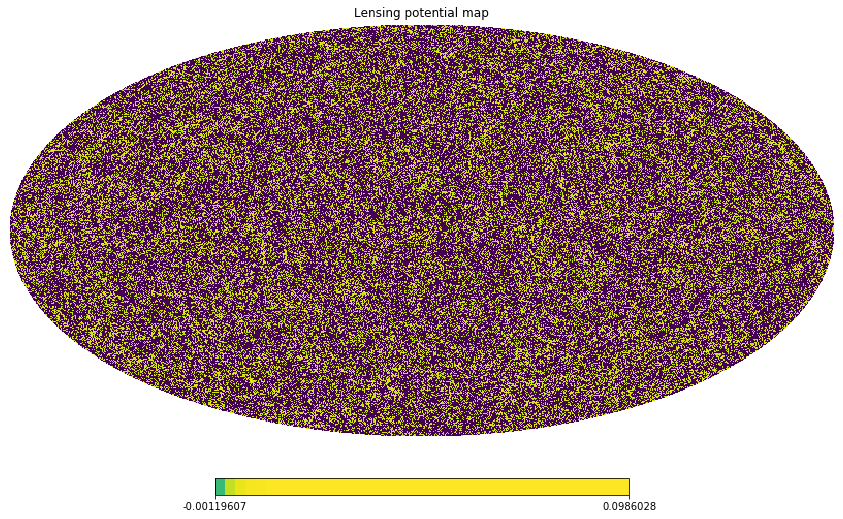

In [233]:
fig0 = plt.figure(figsize = (12,12))
hp.mollview(sigma, fig = fig0.number, norm = 'hist', title = 'Lensing potential map')

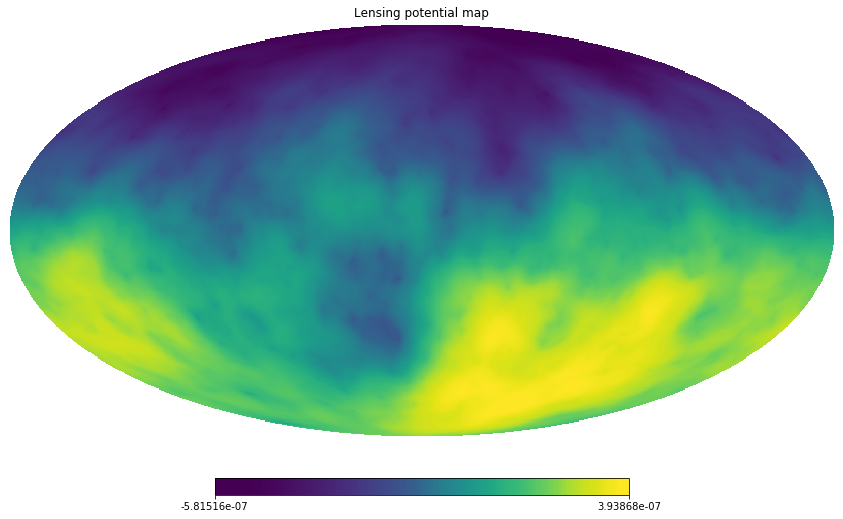

In [234]:
fig0 = plt.figure(figsize = (12,12))
hp.mollview(psi, fig = fig0.number, norm = 'hist', title = 'Lensing potential map')

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


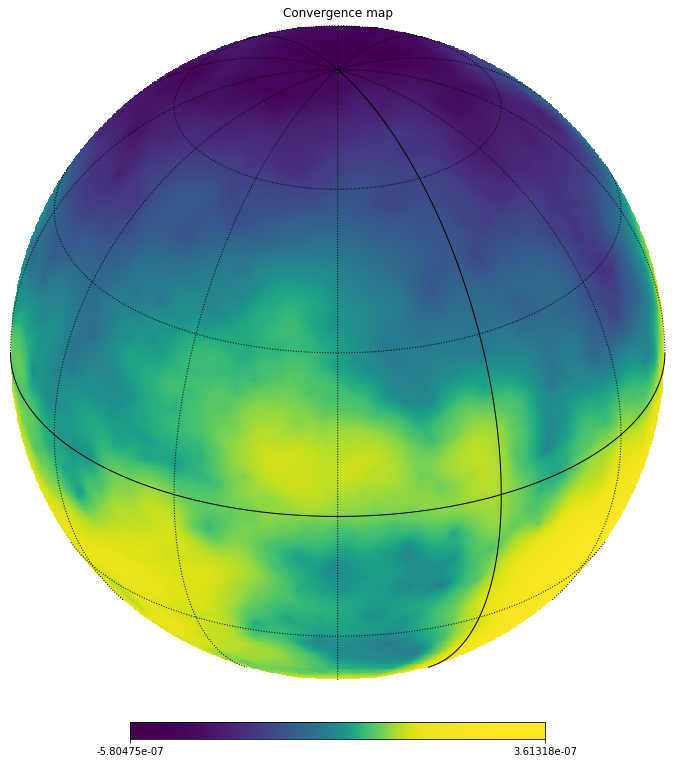

In [237]:
fig2 = plt.figure(figsize = (12,12))
hp.orthview(psi, norm = 'hist', fig = fig2.number, title = 'Convergence map', half_sky = True, rot = (30,30,0))
hp.graticule()

In [238]:
gamma_t = np.sqrt(d_theta*d_theta + d_phi*d_phi)

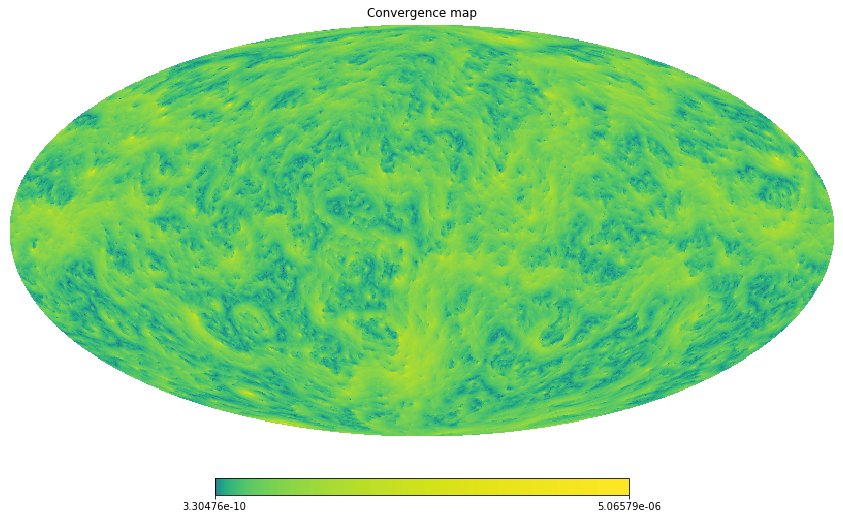

In [239]:
fig1 = plt.figure(figsize = (12,12))
hp.mollview(gamma_t, norm = 'log', fig = fig1.number, title = 'Convergence map')
plt.savefig('Convergence map, nside={0:0d}'.format(nside))

In [219]:
n = 100
res = 10
x = np.arange(0, n)
y = np.arange(0, n)
xv, yv = np.meshgrid(x, y)

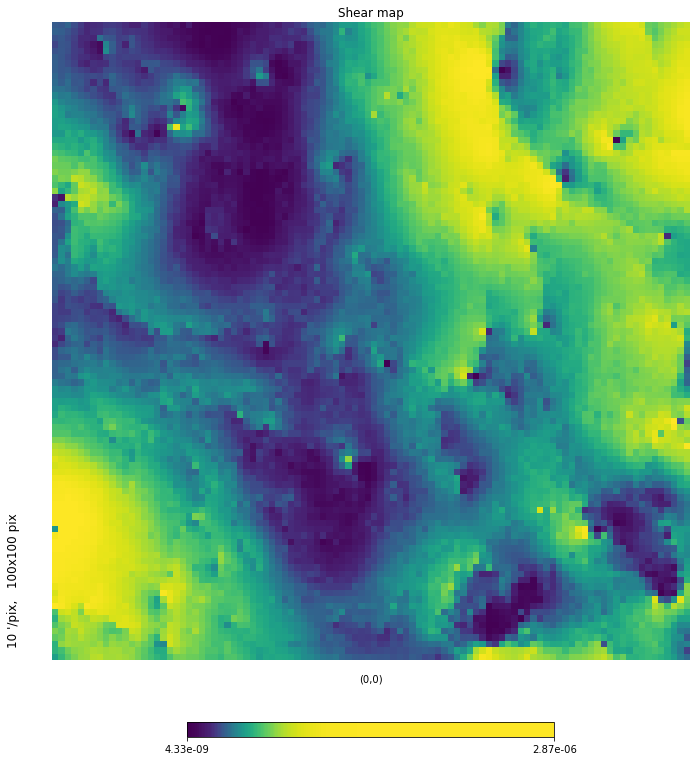

In [242]:
fig = plt.figure(figsize = (12,12))
proj_map = hp.gnomview(gamma_t, fig = fig.number, norm = 'hist', xsize = n, reso = res, return_projected_map = True, title = 'Shear map')
#hp.graticule()
plt.savefig('Shear map: nside = {0:0d}, pixels = {1:0d}, res = {2:0.0f}'.format(nside,n, res))

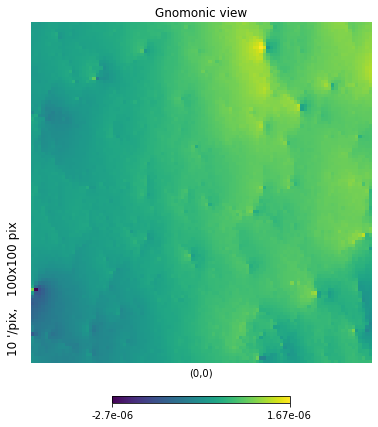

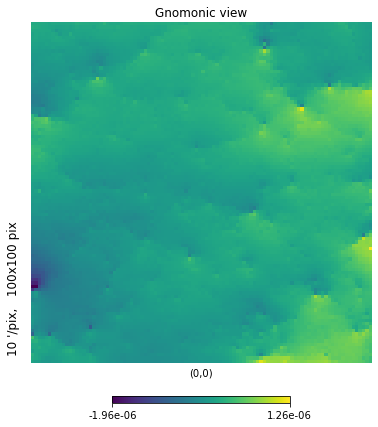

In [221]:
u = hp.gnomview(d_phi, xsize = n, reso = res, return_projected_map = True)
v = -hp.gnomview(d_theta, xsize = n, reso = res, return_projected_map = True)
#u /= 1000
#v /= 1000

In [222]:
Levels = [1,10,20, 50, 100, 200, 500, 1000,2000]

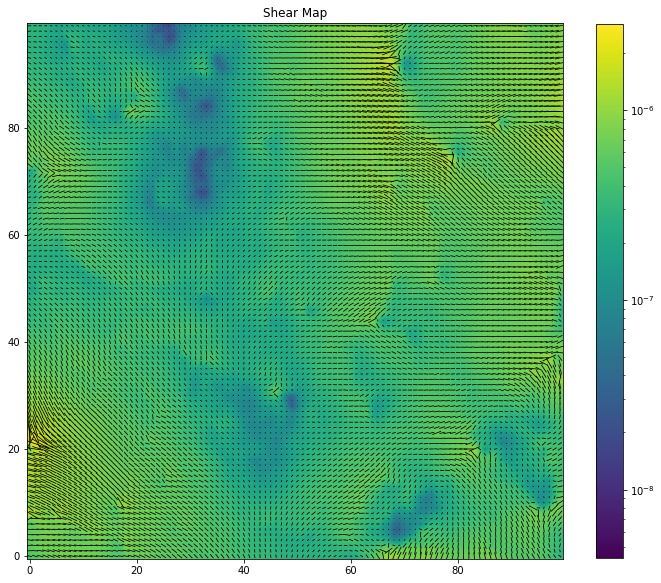

In [247]:
Cmap = cm.get_cmap('viridis')
Interp = 'bicubic'
#Norm = cm.colors.Normalize(proj_map.min(), proj_map.max())
Norm = cm.colors.LogNorm(proj_map.min(), proj_map.max())
fig2 = plt.figure(figsize = (12,12))
ax = fig2.gca()
img = ax.imshow(proj_map,cmap = Cmap, norm = Norm, interpolation = Interp, origin='lower')
#cont = ax.contour(xv,yv, proj_map, norm=Norm,levels = Levels)
qiv  = ax.quiver(xv,yv,u,v, pivot ='mid', scale= 0.00005, width = 0.0015, headlength=0, headwidth=0, headaxislength=0)
plt.colorbar(mappable = img,shrink = 0.82)
plt.title('Shear Map')
plt.savefig('Shear plot SHT: nside = {0:0d}, pixels = {1:0d}, res = {2:0.0f}'.format(nside,n, res))
plt.show()

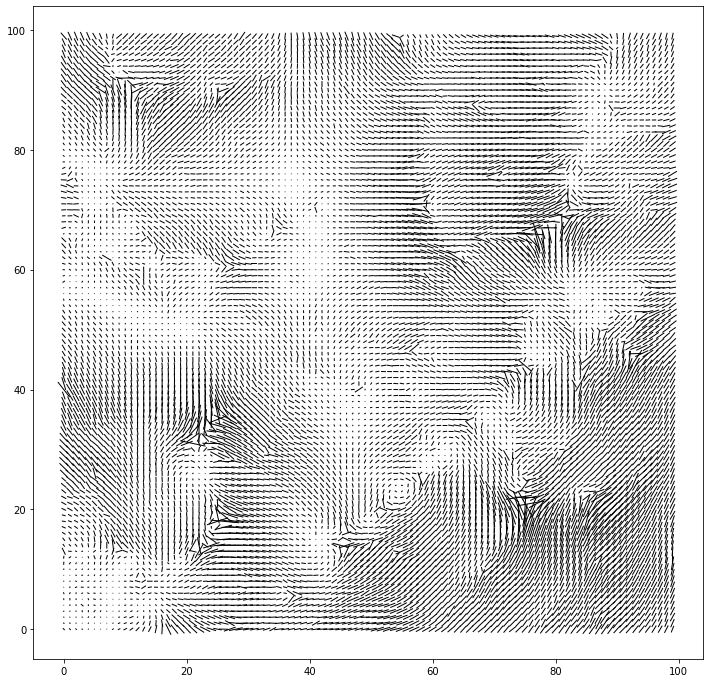

In [198]:
fig3 = plt.figure(figsize = (12,12))
ax = fig3.gca()
qiv  = ax.quiver(xv,yv,u,v, pivot ='mid', scale= 0.00001, width = 0.0015, headlength=0, headwidth=0, headaxislength=0)
plt.show()

In [225]:
print('anafast started', datetime.now())
cl = hp.anafast(gamma_t, alm = False)
ell = np.arange(len(cl))
print('anafast completed', datetime.now())

anafast started 2020-03-13 20:44:00.714121
anafast completed 2020-03-13 20:44:17.173539


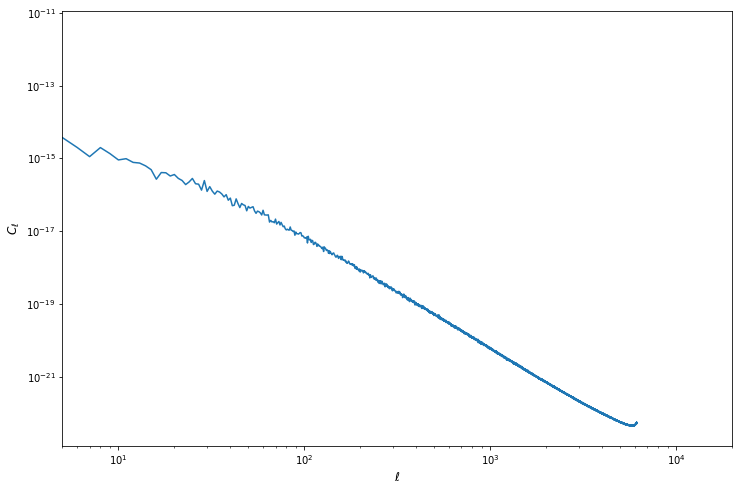

In [227]:
plt.figure(figsize = (12,8))
plt.loglog(ell,cl)
plt.xlabel('$\ell$', size = 'large')
plt.ylabel('$C_{\ell}$', size = 'large')
plt.xlim(5, 2e4)
#plt.ylim(1e-9,1e-3)
plt.show()

In [228]:
cl2 = cl * (ell*(1+ell))/(2*np.pi)

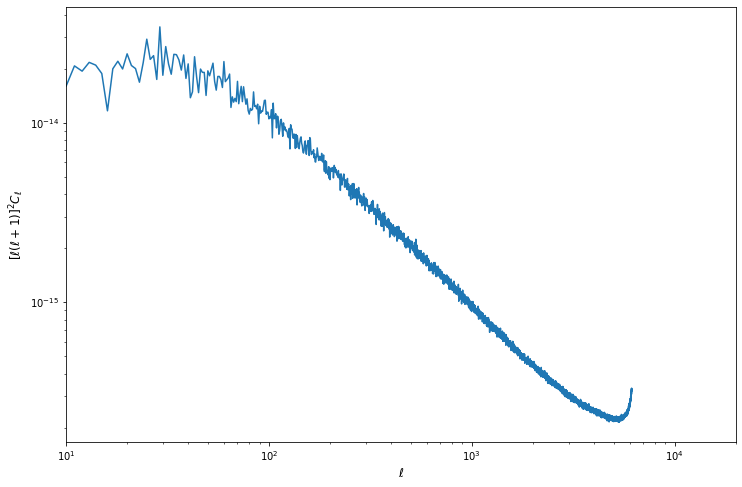

In [229]:
plt.figure(figsize = (12,8))
plt.loglog(ell,cl2)
plt.xlabel('$\ell$', size = 'large')
plt.ylabel('$[\ell(\ell+1)]^2C_{\ell}$', size = 'large')
plt.xlim(1e1, 2e4)
#plt.ylim(1e-3,1e0)
plt.show()

In [244]:
print('anafast started', datetime.now())
cl = hp.anafast(psi, alm = False)
ell = np.arange(len(cl))
print('anafast completed', datetime.now())

anafast started 2020-03-13 22:10:01.029846
anafast completed 2020-03-13 22:10:14.311056


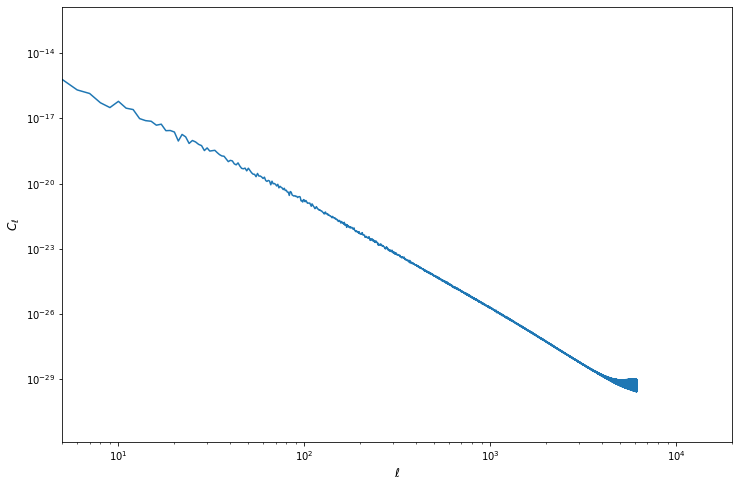

In [245]:
plt.figure(figsize = (12,8))
plt.loglog(ell,cl)
plt.xlabel('$\ell$', size = 'large')
plt.ylabel('$C_{\ell}$', size = 'large')
plt.xlim(5, 2e4)
#plt.ylim(1e-9,1e-3)
plt.show()